# Part II: Get metadata

- Number of transcripts per cell and per gene
- Relate original cell ID with `ndimage` one
- Some other data related to cell and overall concentration

In [1]:
import numpy as np
import pandas as pd
import tifffile as tf
from glob import glob
import os
from scipy import ndimage
from matplotlib import pyplot as plt

from importlib import reload
import utils

# Load all general data

- Same setup as in Part I

In [2]:
PP = 0
min_n_ratio = 0.05
max_N_ratio = 0.55
fs = 15
tol = 0.999

sample = 'D2'

wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
nsrc = os.pardir + os.sep + 'nuclear_mask' + os.sep
tsrc = os.pardir + os.sep + 'translocs' + os.sep + sample + os.sep
psrc = os.pardir + os.sep + 'proc' + os.sep
csrc = os.pardir + os.sep + 'data' + os.sep + sample + '_data' + os.sep

dst = os.pardir + os.sep + 'kde' + os.sep +  sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
nuclei = tf.imread(nsrc + sample + '_EDT.tif') < 1

- Load all the CSVs with spatial locations

In [3]:
filenames = sorted(glob(tsrc + '*.csv'))
tsize = np.zeros(len(filenames), dtype=int)
transcriptomes = [os.path.splitext(filenames[i])[0].split('_-_')[-1] for i in range(len(filenames)) ]
translocs = [None for _ in range(len(filenames))]
for i in range(len(filenames)):
    translocs[i] = pd.read_csv(filenames[i], header=None, names=['X', 'Y', 'Z'])
    tsize[i] = len(translocs[i])

tlocs = pd.concat(translocs)

# Compute metadata for every cell

Get metadata for every cell.

From the initial raw files we already have:

- Cell ID from the original data
- Originally computed center of mass

In [4]:
fname = csrc + transcriptomes[1] + os.sep + transcriptomes[1] + ' - localization results by cell.csv'
celllocs = utils.celllocs_read(fname)
celllocs.head()

,Cell.ID..,X.location,Y.location,Bouding.box.X,Bouding.box.Y,Bouding.box.width,Bouding.box.height,Cell.Area..px.,Nucleus.Area..px.,Total.transcript..,...,Median.distance.from.nucleus.excl..nucleus..px.,X1st.quartile.distance.w..nucleus..px.,X1st.quartile.distance.w.o.nucleus..px.,X3rd.quartile.distance.w..nucleus..px.,X3rd.quartile.distance.w.o.nucleus..px.,nuclear.only.transcripts,U,average.nuclear.transcript.percentage,Total.cells.expressed,Nuc_cells_exp
1,1,7865.122,8160.490,0,0,17152,17152,114809255,36236,7,...,546.0,397.0,397.0,823.0,823.0,0.0,NaN,0.0,653,327
2,2,8635.463,1576.646,8334,1294,600,683,219417,1351,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,653,327
3,3,9013.470,1470.260,8894,1318,256,279,41482,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,653,327
4,4,10999.036,1460.482,10791,1338,429,251,76067,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,653,327
5,5,7894.778,1596.058,7741,1363,306,459,84310,870,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,653,327


The index is the label ID matched from `ndimage` (matching done by comparing centers of mass). Now with `ndimage` we can extract from the raw cell-wall TIFF files:

-  Lower-left and upper right corners of the minimal bounding box containing the cell
-  Length and height of such box
-  Total cell area
-  Total area occupied by nuclei
-  Total area occupied by cytosol
-  Cytosol-to-total area ratio
-  Center of mass according to `ndimage` computed right now
-  Cell ID from the original data

In [7]:
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
objss = ndimage.find_objects(label)
print('Detected',cellnum,'cells')

dcoords, cnuclei, argmatches, orig_cellID = utils.match_original_ndimage(celllocs, wall, label, cellnum)
meta = utils.generate_cell_metadata(label, objss, nuclei)
meta['ndimage_cellID'] = np.arange(1,cellnum+1)
meta = meta.set_index(keys=['ndimage_cellID'])

orig_com = np.round(dcoords[argmatches], 2)
orig_com[orig_cellID == 0] = 0
meta = meta.join(pd.DataFrame( orig_com, columns=['orig_comX', 'orig_comY'], index=meta.index))
meta = meta.join(pd.DataFrame(np.round(np.flip(cnuclei, axis=1),2), columns=['ndimage_comX', 'ndimage_comY'], index=meta.index))
meta['orig_cellID'] = orig_cellID

print('Number of unmatched ndimage labels:\t', len(meta.loc[meta['orig_cellID'] == 0]) )
uq, ct = np.unique(metacell.loc[metacell['orig_cellID'] > 0, 'orig_cellID'].values, return_counts=True)
print('Number of cells with more than one match:\t', np.sum(ct > 1))

meta.head()

Detected 2937 cells


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID
ndimage_cellID,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,7865.12,8160.49,7865.56,8160.76,1
2,8333,8935,1293,1979,602,686,222903,1351,221552,0.993939,8635.46,1576.65,8635.18,1577.03,2
3,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,9013.47,1470.26,9013.07,1469.69,3
4,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,10999.04,1460.48,10998.62,1459.99,4
5,7740,8048,1362,1823,308,461,86041,870,85171,0.989889,7894.78,1596.06,7894.19,1595.83,5


And now using the raw nuclei TIFF files we can compute:
- the number of nuclei inside the cell

In [8]:
lnuc, nnuc = ndimage.label(nuclei, ndimage.generate_binary_structure(2,1))
nuc_area, _ = np.histogram(lnuc, bins=np.arange(nnuc + 2))
nuc_area[0] = 0
print('Detected',nnuc,'nuclei')

number_nuclei = np.zeros(len(meta), dtype=int)
for i in np.nonzero(meta['nuclei_area'] > 100)[0]:
    cidx = meta.iloc[i].name
    ss = (np.s_[max([0, meta.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], meta.loc[cidx, 'y1'] + PP])],
          np.s_[max([1, meta.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], meta.loc[cidx, 'x1'] + PP])])
    
    uq, ct = np.unique(lnuc[ss][(lnuc[ss] > 0) & (label[ss] == cidx)], return_counts=True)
    number_nuclei[i] = np.sum( ( (ct/np.sum(ct)) > min_n_ratio ) & (ct/nuc_area[uq] > max_N_ratio) )

meta['number_nuclei'] = number_nuclei
meta.head()

Detected 1365 nuclei


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,number_nuclei
ndimage_cellID,,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,7865.12,8160.49,7865.56,8160.76,1,0
2,8333,8935,1293,1979,602,686,222903,1351,221552,0.993939,8635.46,1576.65,8635.18,1577.03,2,1
3,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,9013.47,1470.26,9013.07,1469.69,3,0
4,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,10999.04,1460.48,10998.62,1459.99,4,0
5,7740,8048,1362,1823,308,461,86041,870,85171,0.989889,7894.78,1596.06,7894.19,1595.83,5,1


Using the X, Y, Z coordinates and the estimated Z-location of nuclei, we can estimate volumes:

- Cell volume
- Cytosolic volume
- Nuclear volume

Instead of considering the Z-limits shown by the data, we consider the 0.001 and 0.999 quantiles to remove outlier effects.

In [18]:
zhist, bins = np.histogram(tlocs['Z'].values, bins=range(tlocs['Z'].min(),tlocs['Z'].max()+2))

foo = np.argsort(zhist)[::-1]
bar = np.nonzero(np.cumsum(zhist[foo])/np.sum(zhist) < tol)[0]
zmin = bins[foo][bar].min()
zmax = bins[foo][bar].max()+1
print('Z-min:\t',zmin, '\t...\tZ-max:\t',zmax, sep='')

meta['total_volume'] = meta['total_area']*(zmax - zmin)

cell_nuc = pd.read_csv(dst + sample + '_nuclei_limits.csv')
cell_nuc.loc[ cell_nuc['n_bot'] < zmin , 'n_bot' ] = zmin
cell_nuc.loc[ cell_nuc['n_top'] > zmax , 'n_top' ] = zmax

nvol = pd.Series(0, index=meta.index)
PP = 5
for cidx in meta.index.values:
    s_ = (np.s_[max([0, meta.loc[cidx, 'y0'] - PP]) : min([label.shape[0], meta.loc[cidx, 'y1'] + PP])],
          np.s_[max([1, meta.loc[cidx, 'x0'] - PP]) : min([label.shape[1], meta.loc[cidx, 'x1'] + PP])])
    nucdf = cell_nuc[cell_nuc['ndimage_ID'] == cidx]
    for k in range(len(nucdf)):
        nidx, n_bot, n_top = nucdf.iloc[k][ ['nuc_ID', 'n_bot', 'n_top']].values.astype(int)
        if n_bot < n_top:
            h = n_top - n_bot
        else:
            h = (zmax - n_bot) + (n_top - zmin)
        nvol.loc[cidx] += h*np.sum( (lnuc[s_] == nidx) & (label[s_] == cidx) )

meta['cyto_volume'] = meta['total_volume'] - nvol
meta['nuclei_volume'] = nvol
meta.head()

Z-min:	11	...	Z-max:	52


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,number_nuclei,total_volume,cyto_volume,nuclei_volume
ndimage_cellID,,,,,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,7865.12,8160.49,7865.56,8160.76,1,0,4711375231,4709860281,1514950
2,8333,8935,1293,1979,602,686,222903,1351,221552,0.993939,8635.46,1576.65,8635.18,1577.03,2,1,9139023,9083632,55391
3,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,9013.47,1470.26,9013.07,1469.69,3,0,1746764,1746764,0
4,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,10999.04,1460.48,10998.62,1459.99,4,0,3175983,3175983,0
5,7740,8048,1362,1823,308,461,86041,870,85171,0.989889,7894.78,1596.06,7894.19,1595.83,5,1,3527681,3492011,35670


In [32]:
filename = dst + sample + '_cells_metadata.csv'
meta.to_csv(filename, index_label='ndimage_cellID')
print('Created:\t', filename)

metacell = pd.read_csv(filename, index_col='ndimage_cellID')
print(metacell.shape)
metacell.loc[:,['length', 'height']].describe().astype(int).T

Created:	 ../kde/D2/D2_cells_metadata.csv
(2937, 19)


,count,mean,std,min,25%,50%,75%,max
length,2937,309,336,77,209,278,372,17152
height,2937,309,338,81,205,278,379,17152


---

# Compute metadata for every gene

Count both total transcripts and purely cytosolic ones

- Total number of transcripts throughout the cross section
- Total number of transcripts floating in cytosol
- Total number floating in nuclei
- Cytosolic-to-total transcript ratio

In [34]:
filename = dst + sample + '_transcripts_metadata.csv'

data = pd.read_csv(csrc + '32771-slide1_' + sample + '_results.txt', header=None, sep='\t').drop(columns=[4])
_, orig_size = np.unique(data.iloc[:,-1], return_index = False, return_inverse=False, return_counts=True) 
meta = pd.DataFrame()
meta['total_number'] = orig_size
meta['cyto_number'] = tsize
meta['nuclei_number'] = orig_size - tsize
meta['ratio'] = tsize/orig_size
meta['gene'] = transcriptomes
    
meta.to_csv(filename, index=False)
metatrans = pd.read_csv(filename, index_col='gene')
metatrans.head()

,total_number,cyto_number,nuclei_number,ratio
gene,,,,
BAC45727,32613,32613,0,1.0
BAC46169,1162,1162,0,1.0
BAC47034,1820064,1820064,0,1.0
BAC47856,1939,1939,0,1.0
BAC48395,3033,3033,0,1.0


---

## Compute metadata for every cell and gene

- Number of **cytosolic** transcripts of a given gene in a given cell

In [42]:
filename = dst + sample + '_transcells_metadata.csv'

meta = utils.generate_transcell_metadata(translocs, transcriptomes, cellnum, label)
meta.to_csv(filename, index=False)

transcell = pd.read_csv(filename, index_col='gene')
transcell.head()

,1,2,3,4,5,6,7,8,9,10,...,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937
gene,,,,,,,,,,,,,,,,,,,,,
BAC45727,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BAC46169,7,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
BAC47034,859,1,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,2,0,0,0
BAC47856,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BAC48395,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Include nuclear transcripts in the `transcell` file

In [18]:
src = os.pardir + os.sep + 'Bacteria Info for Erik' + os.sep
for i in range(len(transcriptomes)):
    filename = src + transcriptomes[i] + '_v2.txt'
    translocs[i] = pd.read_csv(filename, sep='\t')
tlocs = pd.concat(translocs)

filename = dst + sample + '_transcells_metadata_w_nucleus.csv'
print(filename)
if os.path.isfile(filename):
    meta2 = utils.generate_transcell_metadata(translocs, transcriptomes, cellnum, label)
    meta.to_csv(filename, index=False)
transcell = pd.read_csv(filename)
transcell.head()

os.pardir/kde/D2/D2_transcells_metadata_w_nucleus.csv


# Plot on the distribution of Z-coordinates

../kde/D2/D2_zaxis_distribution.


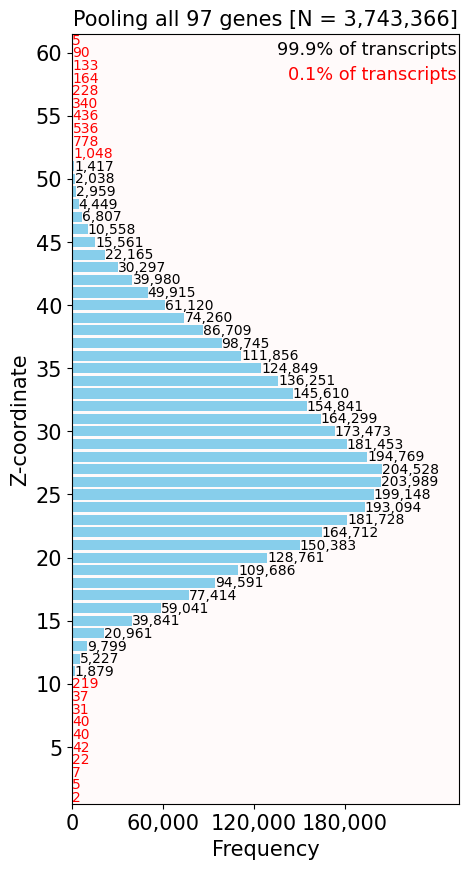

In [33]:
fig, ax = plt.subplots( 1,1, figsize=(5, 10), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].set_facecolor('snow')
ax[i].barh(bins[:-1], zhist, color='skyblue')
ax[i].set_xlim(0, 1.25*zhist.max())
ax[i].set_ylim(tlocs['Z'].min()-0.5, tlocs['Z'].max()+0.5)
ax[i].set_ylabel('Z-coordinate', fontsize=fs)
ax[i].set_xlabel('Frequency', fontsize=fs)
ax[i].set_title('Pooling all {} genes [N = {:,}]'.format(len(transcriptomes), len(tlocs)), fontsize=fs)
ax[i].tick_params(labelsize=fs)
ax[i].set_yticks(np.arange(0, tlocs['Z'].max(), 5)[1:], np.arange(0, tlocs['Z'].max() ,5)[1:])
ax[i].set_xticks(np.arange(0, zhist.max()+1, 6e4), ['{:,}'.format(x) for x in np.arange(0, zhist.max()+1, 6e4).astype(int)] )
for j in range(len(zhist)):
    if zhist[j] < zhist[foo][bar[-1]] - 1:
        c = 'r'
    else:
        c = 'k'
    ax[i].text(zhist[j], bins[j], '{:,}'.format(zhist[j]), color=c, ha='left', va='center')
ax[i].text(1.24*zhist.max(), bins[-2], '{:.1f}% of transcripts'.format(tol*100), ha='right', va='top', fontsize=0.85*fs)
ax[i].text(1.24*zhist.max(), bins[-4], '{:.1f}% of transcripts'.format(100-tol*100), ha='right', va='top', fontsize=0.85*fs, c='r')
filename = dst + sample + '_zaxis_distribution.'
print(filename)
#fig.savefig(filename + 'pdf', format='pdf', bbox_inches='tight',transparent=False)